In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf

In [ ]:
import glob
images=glob.glob('/content/drive/MyDrive/archive (2)/seg_pred/seg_pred'+'/*jpg')

In [ ]:
print('Total Images in Directory: ',len(images))

Total Images in Directory:  6492


In [ ]:
def generate_mask(arr):
  # Generating a mask of 30 X 30.
  for i in range(65,96,1):
    for j in range(65,96,1):
      arr[i][j][0]=255
      arr[i][j][1]=255
      arr[i][j][2]=255
  return arr

In [ ]:
from keras.preprocessing.image import img_to_array
import PIL
import cv2
from PIL import Image
dataset,dataset_mask=[],[]
cnt=0;
for ele in images:
  if cnt==3000:
    break;
  img=cv2.imread(ele)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_d=cv2.resize(img,(160,160))
  img = img.astype('float32') / 255.0
  dataset.append(np.array(img_d))
  dataset_mask.append(generate_mask(np.array(img_d)))
  cnt+=1

In [ ]:
data_array=np.array(dataset)
data_array_mask=np.array(dataset_mask)
data_array.shape

(3000, 160, 160, 3)

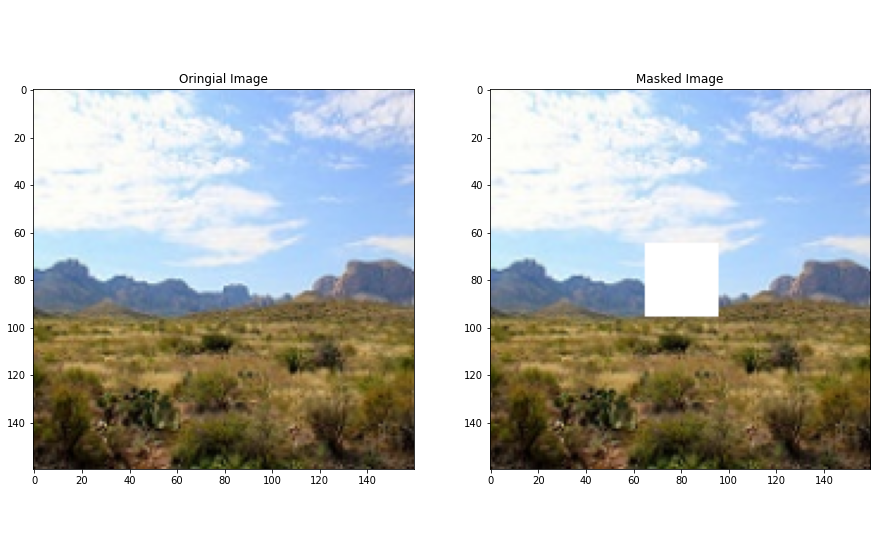

In [ ]:
fig_a=plt.figure(figsize=(15,10))
plt.axis("off")
ax1=fig_a.add_subplot(1,2,1)
ax1.set_title("Oringial Image")
ax1=plt.imshow(data_array[32])
ax2=fig_a.add_subplot(1,2,2)
ax2.set_title("Masked Image")
ax2=plt.imshow(data_array_mask[32])

Generating a mask over images of diffrent sizes(30 X 30) 

In [ ]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [ ]:
import keras
def generator_model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
model_context=generator_model()
# Model Summary.
model_context.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 80, 80, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 40, 40, 128)  147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 20, 20, 256)  296192      ['sequential_1[0][0]']       

In [ ]:
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization
def build_discriminator():
  inputs = layers.Input(shape= [160,160,3])
  dis_1 = down(128,(3,3),False)(inputs)
  dis_2 = down(256,(3,3),True)(dis_1)
  dis_3 = down(512,(3,3),True)(dis_2)
  dis_4 = down(512,(3,3),True)(dis_3)
  dis_flat=Flatten()(dis_4)
  prob=Dense(1,activation='sigmoid')(dis_flat)
  return tf.keras.Model(inputs=inputs,outputs=prob)

In [ ]:
model_disc=build_discriminator()
# Model Summary of Discriminator.
model_disc.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_10 (Sequential)  (None, 80, 80, 128)       3584      
                                                                 
 sequential_11 (Sequential)  (None, 40, 40, 256)       296192    
                                                                 
 sequential_12 (Sequential)  (None, 20, 20, 512)       1182208   
                                                                 
 sequential_13 (Sequential)  (None, 10, 10, 512)       2361856   
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1)                 5120

Combined Training of reducing Re-construction and Adversarial Loss.

In [ ]:
# Compiling a Generator Model.
from tensorflow.keras import losses
from tensorflow import keras
opt=keras.optimizers.Adam(learning_rate=0.001)
model_context.compile(optimizer=opt,loss=losses.MeanSquaredError())

In [ ]:
# Compiling a Discriminator Model.
from tensorflow.keras import losses
from tensorflow import keras
opt=keras.optimizers.Adam(learning_rate=0.001)
model_disc.compile(optimizer=opt,loss=losses.MeanSquaredError())

In [ ]:
from keras.engine.input_layer import Input
# Combined Training
model_disc.trainable=False
input_gen=Input(shape=[160,160,3])
generated_img=model_context(input_gen)
gan_output=model_disc(generated_img)
model_combine=tf.keras.Model(input_gen,gan_output)

In [ ]:
model_combine.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 model (Functional)          (None, 160, 160, 3)       9602766   
                                                                 
 model_3 (Functional)        (None, 1)                 3895041   
                                                                 
Total params: 13,497,807
Trainable params: 9,600,206
Non-trainable params: 3,897,601
_________________________________________________________________


In [ ]:
from tensorflow.keras import losses
from tensorflow import keras
opt=keras.optimizers.Adam(learning_rate=0.001)
model_combine.compile(optimizer=opt,loss=losses.MeanSquaredError())

In [ ]:
import gc
gc.collect()

27927

In [ ]:
# Real Data will be our original images and fake images will be processed image 
for epoch in range(50):
  # ---------------------
  #  Train Discriminator
  # ---------------------
  print("At Epoch: ",epoch+1)
  # Select a random half batch of images
  idx = np.random.randint(0, data_array.shape[0], 150)
  print("Selected 150 Random Images for Training!!!")
  real_imgs = data_array[idx]
  fake_imgs=model_context.predict(data_array_mask[idx])
  # Generate a half batch of new images
  valid = np.ones((150, 1)).astype('float32')
  fake = np.zeros((150, 1)).astype('float32')

  # Train the discriminator
  d_loss_real = model_disc.train_on_batch(real_imgs, valid)
  d_loss_fake = model_disc.train_on_batch(fake_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  print("Real Loss: ",d_loss_real)
  print("Fake Loss: ",d_loss_fake)
  print("Total Loss: ",d_loss)

  # ---------------------
  #  Train Generator
  # ---------------------
  # Select a random batch of images
  idx = np.random.randint(0, data_array.shape[0], 150)
  masked_imgs = data_array_mask[idx]
  real_imgs_1=data_array[idx]
  #d_loss_gen=model_context.train_on_batch(masked_imgs,real_imgs_1)
  # Generator wants the discriminator to label the generated images as valid
  valid = np.ones((150,1)).astype('float32')
  reconstruction_loss=model_context.fit(data_array_mask,data_array)
  print("Reconstruction Loss: ",reconstruction_loss)
  # Train the generator
  g_loss = model_combine.train_on_batch(masked_imgs,valid)
  print("Combined Loss: ",g_loss)
  print("Epoch Done!!!")
  gc.collect() 

At Epoch:  1
Selected 150 Random Images for Training!!!
Real Loss:  0.30189749598503113
Fake Loss:  1.0
Total Loss:  0.6509487479925156
94/94 [==============================] - 16s 160ms/step - loss: 300.9441
Reconstruction Loss:  <keras.callbacks.History object at 0x7fa0dc63ead0>
Combined Loss:  0.0
Epoch Done!!!
At Epoch:  2
Selected 150 Random Images for Training!!!
Real Loss:  0.0
Fake Loss:  1.0
Total Loss:  0.5
94/94 [==============================] - 15s 164ms/step - loss: 129.2805
Reconstruction Loss:  <keras.callbacks.History object at 0x7fa04dee71d0>
Combined Loss:  0.0
Epoch Done!!!
At Epoch:  3
Selected 150 Random Images for Training!!!
Real Loss:  0.0
Fake Loss:  1.0
Total Loss:  0.5
94/94 [==============================] - 16s 171ms/step - loss: 115.9934
Reconstruction Loss:  <keras.callbacks.History object at 0x7fa0dc66b750>
Combined Loss:  0.0
Epoch Done!!!
At Epoch:  4
Selected 150 Random Images for Training!!!
Real Loss:  0.0
Fake Loss:  1.0
Total Loss:  0.5
94/94 [==

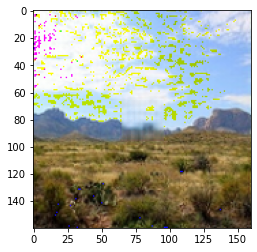

In [ ]:
img_sample=model_context.predict(data_array_mask[32].reshape(1,160,160,3)).astype('uint8').reshape(160,160,3)
plt.imshow(img_sample)  

In [ ]:
def plot_images(color,masked,predicted):
  plt.figure(figsize=(15,15))
  plt.subplot(1,3,1)
  plt.title('Original Image', color = 'green', fontsize = 20)
  plt.imshow(color)
  plt.subplot(1,3,2)
  plt.title('Masked Images',color='Black',fontsize=20)
  plt.imshow(masked)
  plt.subplot(1,3,3)
  plt.title('Predicted Image ', color = 'Red', fontsize = 20)
  plt.imshow(predicted)
  plt.show()

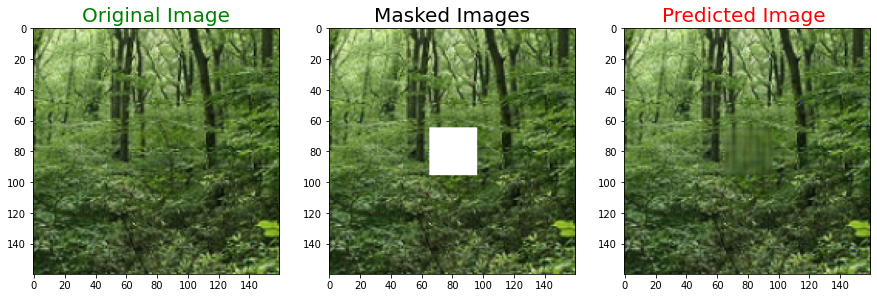

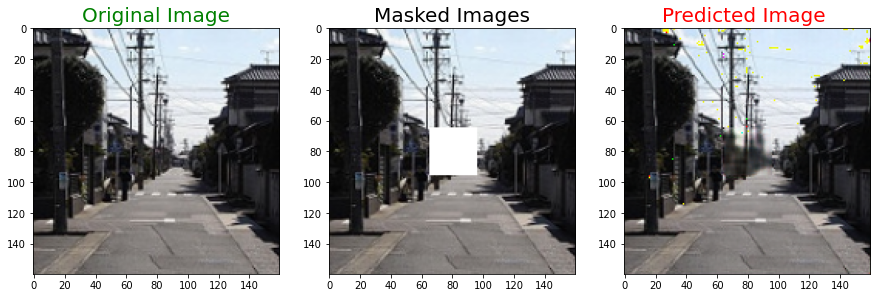

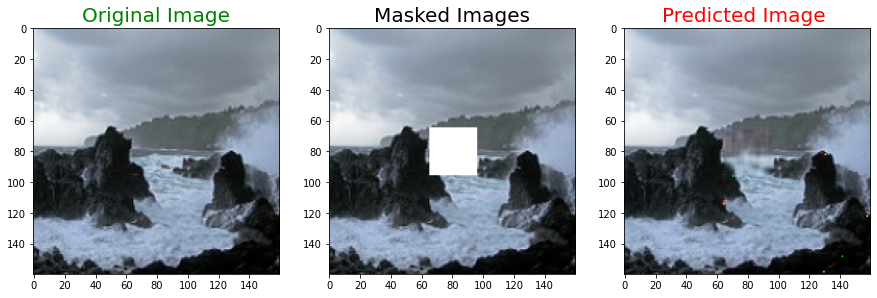

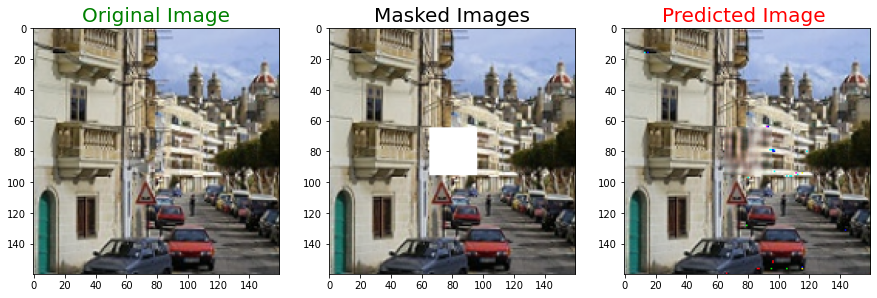

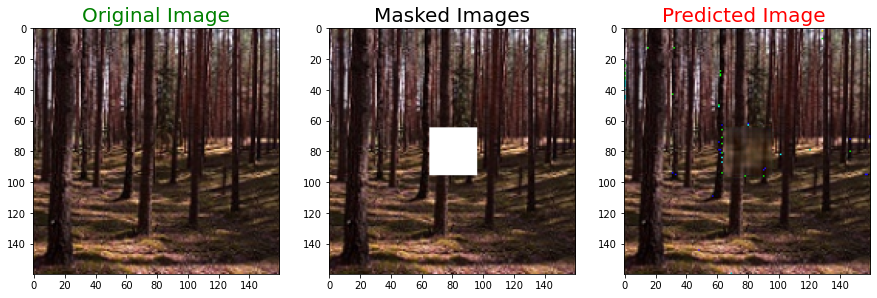

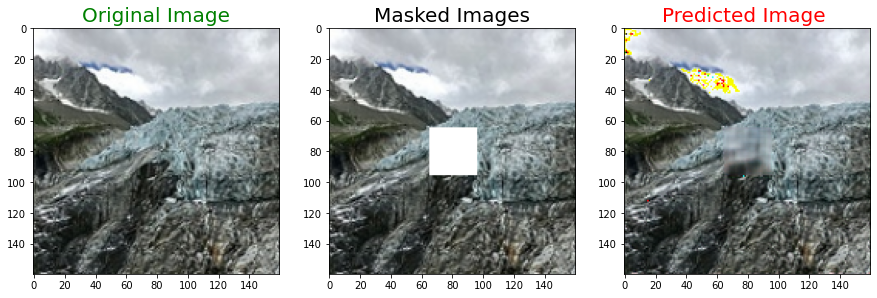

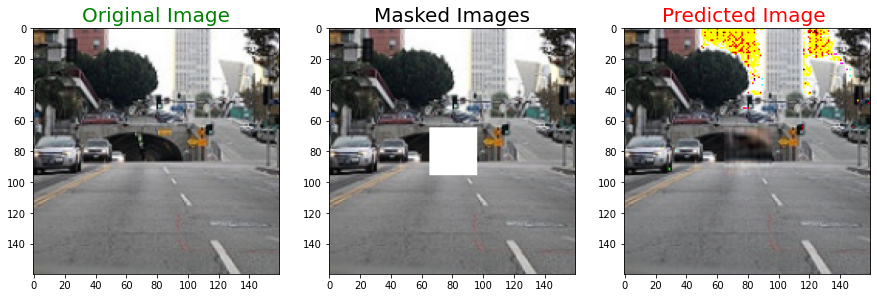

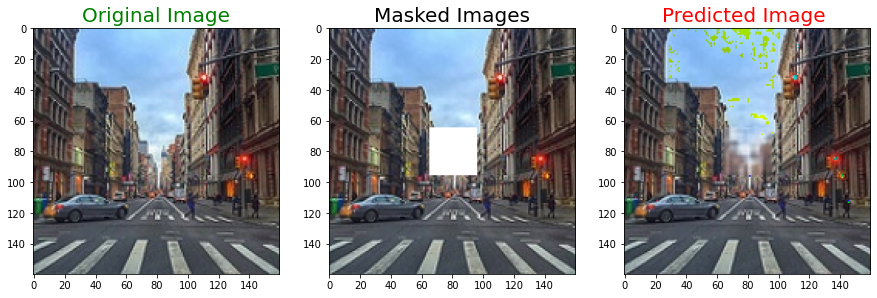

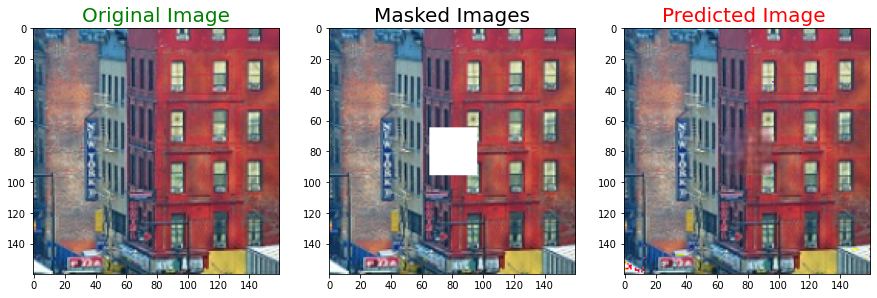

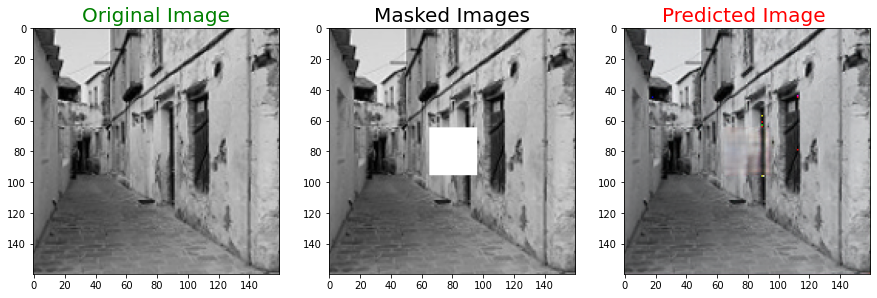

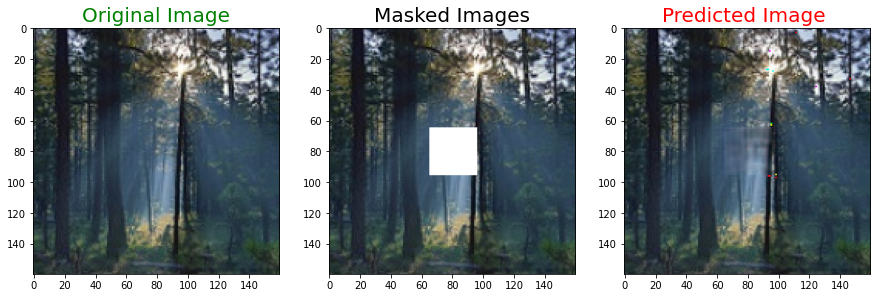

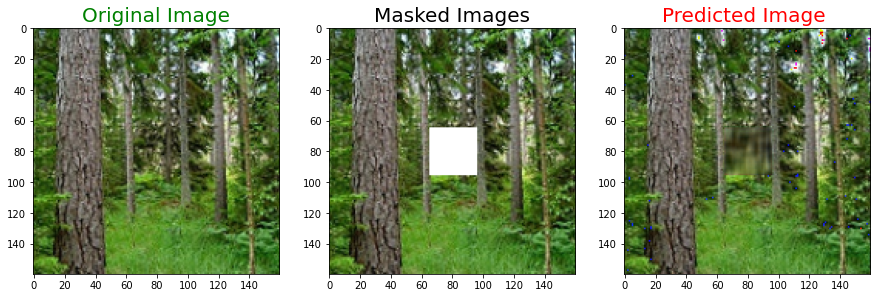

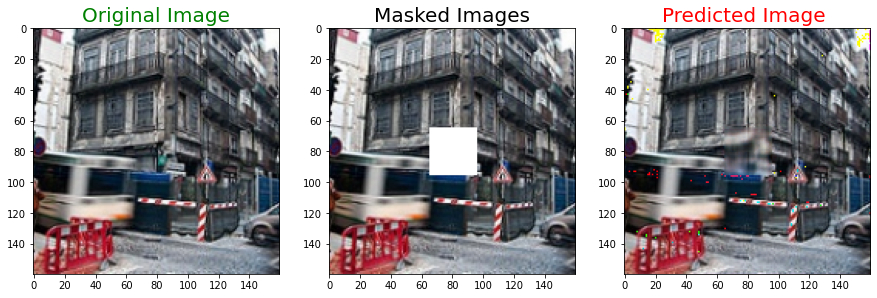

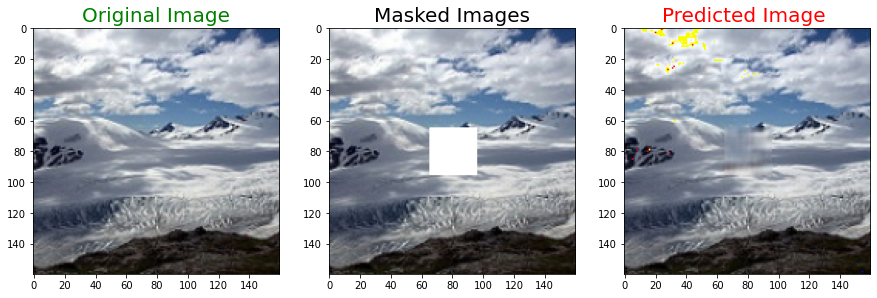

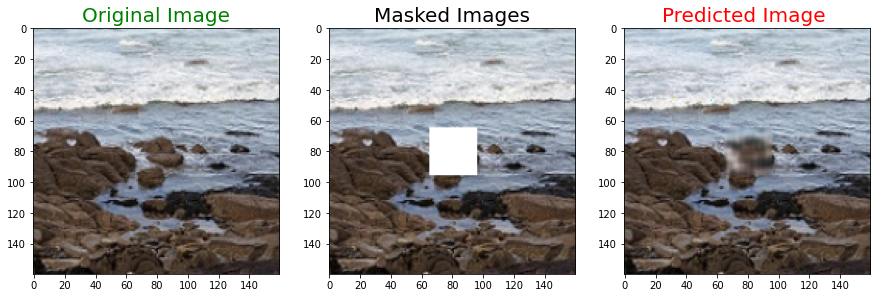

In [ ]:
# Predicting a Image With a Model.
for ind in range(0,15):
  img_pred=model_context.predict(data_array_mask[ind].reshape(1,160, 160,3)).astype('uint8').reshape(160,160,3)
  plot_images(data_array[ind],data_array_mask[ind],img_pred)

In [ ]:
'''for ind in range(0,15,1):
  #img_pred=model_context.predict(data_array_mask[ind].reshape(1,160, 160,3)).astype('uint8').reshape(160,160,3)
  plot_images(data_array[ind],data_array_mask[ind],img_pred[ind])
  '''

"for ind in range(0,15,1):\n  #img_pred=model_context.predict(data_array_mask[ind].reshape(1,160, 160,3)).astype('uint8').reshape(160,160,3)\n  plot_images(data_array[ind],data_array_mask[ind],img_pred[ind])\n  "

In [ ]:
'''
from tensorflow.keras import losses
from tensorflow import keras
opt=keras.optimizers.Adam(learning_rate=0.001)
model_context.compile(optimizer=opt,loss=losses.MeanSquaredError())
'''

'\nfrom tensorflow.keras import losses\nfrom tensorflow import keras\nopt=keras.optimizers.Adam(learning_rate=0.001)\nmodel_context.compile(optimizer=opt,loss=losses.MeanSquaredError())\n'

In [ ]:
#history=model_context.fit(data_array_mask,data_array,epochs=50,shuffle=10,batch_size=64)

In [ ]:
# summarize history for accuracy
#plt.plot(history.history['loss'])
#plt.title('Re-Construction Loss')
#plt.ylabel('Re-Construction Loss')
#plt.xlabel('Epoch')
#plt.show()

In [ ]:
'''
def plot_images(color,masked,predicted):
  plt.figure(figsize=(15,15))
  plt.subplot(1,3,1)
  plt.title('Original Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Masked Images',color='Black',fontsize=20)
    plt.imshow(masked)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
    plt.show()
'''

"\ndef plot_images(color,masked,predicted):\n  plt.figure(figsize=(15,15))\n  plt.subplot(1,3,1)\n  plt.title('Original Image', color = 'green', fontsize = 20)\n    plt.imshow(color)\n    plt.subplot(1,3,2)\n    plt.title('Masked Images',color='Black',fontsize=20)\n    plt.imshow(masked)\n    plt.subplot(1,3,3)\n    plt.title('Predicted Image ', color = 'Red', fontsize = 20)\n    plt.imshow(predicted)\n    plt.show()\n"

In [ ]:
'''
# Predicting a Image With a Model.
img_pred_l=[]
for ind in range(0,data_array_mask.shape[0]):
  img_pred=model_context.predict(data_array_mask[ind].reshape(1,160, 160,3)).astype('uint8').reshape(160,160,3)
  img_pred_l.append(img_pred)
img_pred=np.array(img_pred_l)
'''

"\n# Predicting a Image With a Model.\nimg_pred_l=[]\nfor ind in range(0,data_array_mask.shape[0]):\n  img_pred=model_context.predict(data_array_mask[ind].reshape(1,160, 160,3)).astype('uint8').reshape(160,160,3)\n  img_pred_l.append(img_pred)\nimg_pred=np.array(img_pred_l)\n"

In [ ]:
'''for ind in range(0,15,1):
  #img_pred=model_context.predict(data_array_mask[ind].reshape(1,160, 160,3)).astype('uint8').reshape(160,160,3)
  plot_images(data_array[ind],data_array_mask[ind],img_pred[ind])
'''

"for ind in range(0,15,1):\n  #img_pred=model_context.predict(data_array_mask[ind].reshape(1,160, 160,3)).astype('uint8').reshape(160,160,3)\n  plot_images(data_array[ind],data_array_mask[ind],img_pred[ind])\n"

In [ ]:
#cnt=1
#for ele in img_pred:
  #name='proceesed_'+str(cnt)+'.jpeg'
  #cv2.imwrite('/content/drive/MyDrive/archive (2)/processed_image/'+name,ele)
  #cnt+=1

In [ ]:
#cnt=1
#for ele in data_array_mask:
  #name='masked_'+str(cnt)+'.jpeg'
  #cv2.imwrite('/content/drive/MyDrive/archive (2)/masked_image/'+name,ele)
  #cnt+=1

In [ ]:
'''
from tensorflow.keras.layers import Flatten,Dense
def build_discriminator():
  inputs = layers.Input(shape= [160,160,3])
  dis_1 = down(128,(3,3),False)(inputs)
  dis_2 = down(256,(3,3),True)(dis_1)
  dis_3 = down(512,(3,3),True)(dis_2)
  dis_4 = down(512,(3,3),True)(dis_3)
  dis_flat=Flatten()(dis_4)
  prob=Dense(1,activation='sigmoid')(dis_flat)
  return tf.keras.Model(inputs=inputs,outputs=prob)
'''

"\nfrom tensorflow.keras.layers import Flatten,Dense\ndef build_discriminator():\n  inputs = layers.Input(shape= [160,160,3])\n  dis_1 = down(128,(3,3),False)(inputs)\n  dis_2 = down(256,(3,3),True)(dis_1)\n  dis_3 = down(512,(3,3),True)(dis_2)\n  dis_4 = down(512,(3,3),True)(dis_3)\n  dis_flat=Flatten()(dis_4)\n  prob=Dense(1,activation='sigmoid')(dis_flat)\n  return tf.keras.Model(inputs=inputs,outputs=prob)\n"

In [ ]:
'''
# Building a discriminator of Context-Encoder.
model_gan=build_discriminator()
model_gan.summary()
'''

'\n# Building a discriminator of Context-Encoder.\nmodel_gan=build_discriminator()\nmodel_gan.summary()\n'

In [ ]:
'''
from tensorflow.keras import losses
from tensorflow import keras
opt=keras.optimizers.Adam(learning_rate=0.001)
model_gan.compile(optimizer=opt,loss=losses.MeanSquaredError())
'''

'\nfrom tensorflow.keras import losses\nfrom tensorflow import keras\nopt=keras.optimizers.Adam(learning_rate=0.001)\nmodel_gan.compile(optimizer=opt,loss=losses.MeanSquaredError())\n'

In [ ]:
# # We need to do combine training of GAN.
# data_gan,truth_label=[],[]
# for ind in range(0,3000):
#   data_gan.append(data_array[ind])
#   truth_label.append(1)
# for ind in range(0,1500):
#   data_gan.append(img_pred[ind])
#   truth_label.append(0)
# data_gan_arr,truth_label_arr=np.array(data_gan),np.array(truth_label)

In [ ]:
# disc_real_loss=model_gan.fit(data_gan_arr,truth_label_arr,epochs=10,shuffle=10,batch_size=64)

In [ ]:
# plt.plot(disc_real_loss.history['loss'])
# plt.title('Real Image Loss')
# plt.ylabel('Real Image Loss')
# plt.xlabel('Epoch')
# plt.show()

In [ ]:
# print(model_gan.predict(img_pred[1].reshape(1,160,160,3)))

In [ ]:
# from keras.utils.vis_utils import plot_model
# plot_model(model_context, to_file='encoder_model.png', show_shapes=True, show_layer_names=True,show_layer_activations=True)

In [ ]:
# # Dumping model.
# '''
# import pickle
# pickle_out=open('model_context.pkl',"wb")
# pickle.dump(model_context,pickle_out)
# pickle_out.close()
# '''